# Dano's Multi-Subject Riemann  notebook

In this notebook, I will try and use pyRiemann and data from all subjects to predict cognitive performance from EEG data in Neurodoro

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression
from os import walk
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from tpot import TPOTRegressor
from math import sqrt
import pyriemann
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage
from glob import glob
from pyriemann.utils.viz import plt, plot_confusion_matrix, plot_embedding
from pyriemann.estimation import Covariances, HankelCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.clustering import Potato

Steps

1. Concat all raw datasets together
2. Use Knearest Neighbors in pipeline

In [5]:
# Here are the good raw datasets

#monica = pd.read_csv("../muse-data/MonicaGRawEEG0.csv", header=0, index_col=False)
#monica = monica[:38000]

#dano1 = pd.read_csv("../muse-data/DanoMondayRawEEG0.csv", header=0, index_col=False)
dano2 = pd.read_csv("../muse-data/Dano-08-11-RawEEG0.csv", header=0, index_col=False)
dano3 = pd.read_csv("../muse-data/Dano-08-11-RawEEG3.csv", header=0, index_col=False)

josh = pd.read_csv("../muse-data/josh-raw-aug11RawEEG2.csv", header=0, index_col=False)


In [6]:
# Add them all together

data = pd.concat([dano2,dano3, josh], ignore_index=True)
data = data[data.Performance > -200]
data = data.drop('Timestamp (ms)', axis = 1)
data = data.reset_index(drop=True)


In [7]:
data.values

array([[   0.        ,    0.        ,  623.3119428 ,  569.47553802,
         554.86666436,  599.50488943],
       [   0.        ,    0.        ,  488.1538921 ,  520.50939601,
         520.30181976,  501.38243378],
       [   0.        ,    0.        ,  945.69625968,  968.78854824,
         957.47982276,  955.96262551],
       ..., 
       [   0.        ,   49.        ,  849.54290486,  834.32035196,
         845.04444382,  853.03439506],
       [   0.        ,   49.        ,  851.11483315,  834.24623452,
         845.2635947 ,  852.17794152],
       [   0.        ,   49.        ,  859.65307708,  842.40767739,
         844.75924992,  856.11650068]])

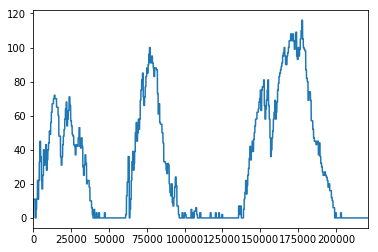

In [8]:
%matplotlib inline
data.Difficulty.plot()

In [26]:
sfreq = 256

# name of each channels 
ch_names = ['Diff', 'TP9', 'FP1', 'FP2', 'TP10']

# type of each channels
ch_types = ['stim'] + ['eeg'] * 4
montage = read_montage('standard_1005')

# get data and exclude Aux channel
data = data.values[:,-5:].T
data

# convert in Volts (from uVolts)
#data[:-1] *= 1e-6

# create mne objects
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
raw = (RawArray(data=data, info=info))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [21]:
data



array([[   0.        ,    0.        ,    0.        , ...,   49.        ,
          49.        ,   49.        ],
       [ 623.3119428 ,  488.1538921 ,  945.69625968, ...,  849.54290486,
         851.11483315,  859.65307708],
       [ 569.47553802,  520.50939601,  968.78854824, ...,  834.32035196,
         834.24623452,  842.40767739],
       [ 554.86666436,  520.30181976,  957.47982276, ...,  845.04444382,
         845.2635947 ,  844.75924992],
       [ 599.50488943,  501.38243378,  955.96262551, ...,  853.03439506,
         852.17794152,  856.11650068]])

tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
Effective window size : 8.000 (s)


<ipython-input-12-39b392d59ea0>:3: DeprecationWarning: tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
  raw.plot_psd(picks=[1]);
/Users/joshharris/anaconda3/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


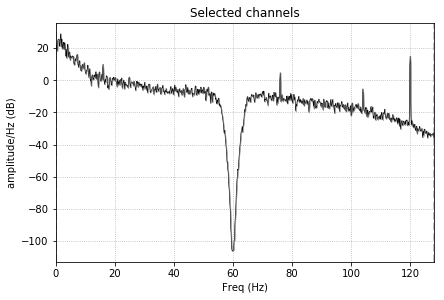

In [12]:
## Plot the PSD of the EEG data just to make sure it looks alright

raw.plot_psd(picks=[1]);


In [22]:
raw.filter(2, 50, method='iir')

Setting up band-pass filter from 2 - 50 Hz


<RawArray  |  None, n_channels x n_times : 5 x 221268 (864.3 sec), ~8.5 MB, data loaded>

## Epochs

In [25]:
raw

<RawArray  |  None, n_channels x n_times : 5 x 221268 (864.3 sec), ~8.5 MB, data loaded>

In [23]:
from mne import make_fixed_length_events, Epochs

# Make an events array with epoch times every .5 seconds
event = make_fixed_length_events(raw, 1, duration=0.5)

# Make an epochs array object from the raw dataset with events array event, length of 2 seconds
epochs = Epochs(raw, event, tmin=0, tmax=4, preload=True)

epochs

1728 matching events found
0 projection items activated
Loading data for 1728 events and 1025 original time points ...
7 bad epochs dropped


<Epochs  |  n_events : 1721 (all good), tmin : 0.0 (s), tmax : 4.0 (s), baseline : (None, 0), ~67.3 MB, data loaded>

In [24]:
epochs

<Epochs  |  n_events : 1721 (all good), tmin : 0.0 (s), tmax : 4.0 (s), baseline : (None, 0), ~67.3 MB, data loaded>

In [15]:
X = epochs.copy().pick_types(eeg=True).get_data()

y = epochs.copy().pick_types(eeg=False, stim=True).get_data().mean(axis=2)
print(X.shape, y.shape)

(1721, 4, 1025) (1721, 1)


In [16]:
X

array([[[  0.00000000e+00,   1.15104956e+02,   2.11737792e+02, ...,
           4.86644695e+01,   4.84264975e+01,   5.16843977e+01],
        [  0.00000000e+00,   1.68577212e+02,   2.92875120e+02, ...,
           5.35678970e+01,   5.54278683e+01,   5.78751797e+01],
        [  0.00000000e+00,   1.75274345e+02,   3.03054306e+02, ...,
           4.96067347e+01,   4.88960425e+01,   4.65760556e+01],
        [  0.00000000e+00,   1.39415210e+02,   2.49751212e+02, ...,
           3.70838749e+01,   4.20994899e+01,   4.64778827e+01]],

       [[  0.00000000e+00,  -3.91569022e-01,   1.17396683e+00, ...,
          -5.45529386e+00,  -5.21658849e+00,  -5.82343161e+00],
        [  0.00000000e+00,  -2.58494976e+00,  -3.98579411e+00, ...,
           7.92886550e+00,   4.45998715e+00,  -3.66139216e-01],
        [  0.00000000e+00,   8.39071785e-01,   8.80281358e-01, ...,
          -4.59597940e+00,  -4.33972566e+00,  -4.83554170e+00],
        [  0.00000000e+00,  -5.21500053e-02,   1.82742344e+00, ...,
      

In [28]:
# Let's transform our data into a covariance matrix and a tangentspace
covs = Covariances(estimator='lwf').fit_transform(X)
#tans = TangentSpace().fit_transform(covs)
#potato = Potato().fit_transform(covs)

In [29]:
covs

array([[[ 756.03382197,  559.45355093,  611.85488998,  748.96250901],
        [ 559.45355093,  750.60030457,  706.15886171,  615.20380886],
        [ 611.85488998,  706.15886171,  783.25837515,  668.09600274],
        [ 748.96250901,  615.20380886,  668.09600274,  921.63154464]],

       [[ 489.16593449,  154.17843581,  201.9805123 ,  383.6768675 ],
        [ 154.17843581,  185.3403758 ,  153.9787366 ,  136.4263165 ],
        [ 201.9805123 ,  153.9787366 ,  199.73217998,  178.81262702],
        [ 383.6768675 ,  136.4263165 ,  178.81262702,  525.44016076]],

       [[ 495.23023487,  160.81531656,  209.45412125,  391.77212528],
        [ 160.81531656,  175.07393306,  157.18492308,  139.64198365],
        [ 209.45412125,  157.18492308,  207.1736108 ,  183.53590262],
        [ 391.77212528,  139.64198365,  183.53590262,  539.76212592]],

       ..., 
       [[  35.35298199,    9.54070438,    5.55096752,   25.17897506],
        [   9.54070438,   33.9438149 ,    2.42345826,    5.21778092],
 

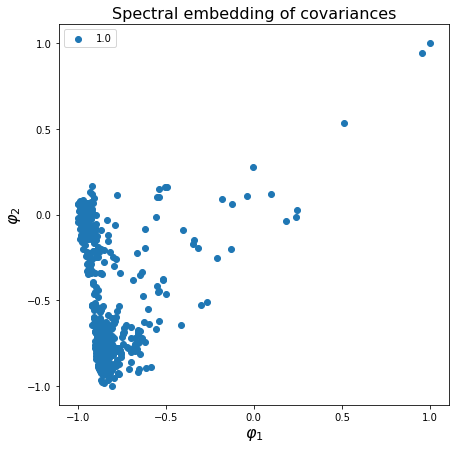

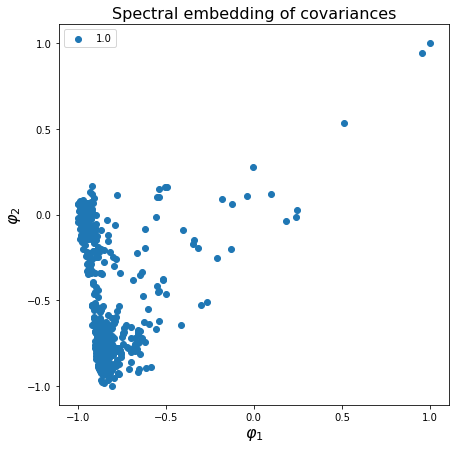

In [14]:
# Now that we have our data setup for sklearn in X and y, let's visualize it

plot_embedding(covs[::3])

In [15]:
# KNeighbors hyperparameters from TPOT
clf = make_pipeline(Covariances(), TangentSpace(), KNeighborsRegressor(n_neighbors=52, p=1, weights="distance"))

clf.fit(X, y)

Pipeline(steps=[('covariances', Covariances(estimator='scm')), ('tangentspace', TangentSpace(metric='riemann', tsupdate=False)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=52, p=1,
          weights='distance'))])

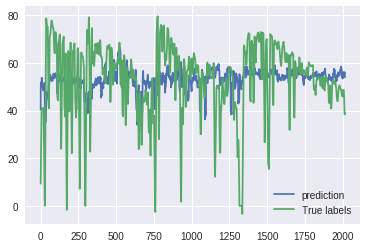

In [41]:
pr = clf.predict(X)
plt.plot(pr)
plt.plot(y)
plt.legend(['prediction', 'True labels'])

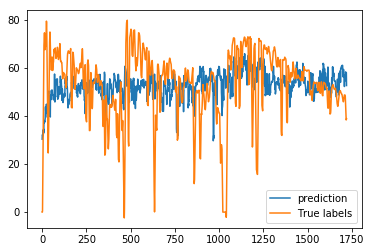

In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict

pr = cross_val_predict(clf, X, y, cv=6)

plt.plot(pr)
plt.plot(y)
plt.legend(['prediction', 'True labels'])

In [17]:
print(sqrt(sk.metrics.mean_squared_error(y, pr)))

14.578906718139136


Mean Squared error with linear regressor = 16.11
Mean Squared error with KNeighboursRegressor = 15.45
